# Corto 4: Locks, Critical y Atomic en Paralelismo

nombre: Joaquin Campos  

Hoy vamos a practicar a manejar **condiciones de carrera** usando Python.

Vamos a hacer referencia a cómo se hace lo mismo en **OpenMP (C)**.

Objetivos:
- Entender bien qué es una condición de carrera.
- Proteger secciones críticas con *locks* (como `#pragma omp critical`).
- Simular operaciones atómicas (como `#pragma omp atomic`).


## 0. Cual es la diferencia entre un Thread y un Proceso?

La diferencia es: 

Un proceso es como una aplicación completa que se está ejecutando (por ejemplo, abrir Word o un navegador).
Un thread es como una tarea dentro de ese proceso (por ejemplo, cargar una página dentro del navegador).

Un proceso tiene su propio espacio de trabajo.

Los threads comparten ese espacio, y por eso son más ligeros y rápidos, pero también más propensos a errores si no se coordinan bien.

## 1. Ejemplo sin protección
Este programa intenta que 5 hilos sumen 100000 cada uno a un contador compartido.

Pregunta: Que esperamsp que ocurra y qué creés que va a pasar en la práctica?

esperamos que el resultado final sea 500000, pero en la práctica seguramente como visto en clase número será mucho menor porque varios hilos están modificando al mismo tiempo el mismo número.

In [33]:
import threading

contador = 0

def incrementar(n):
    global contador
    for _ in range(n):
        contador += 1  # acceso inseguro

hilos = []
for _ in range(5):
    t = threading.Thread(target=incrementar, args=(100000,))
    hilos.append(t)
    t.start()

for t in hilos:
    t.join()

print("Esperado:", 5 * 100000)
print("Obtenido:", contador)

Esperado: 500000
Obtenido: 500000


Se siguio opteniendo 500000, entonces podria ser por el ejemplo pequeño

## 2. Usando Locks (`critical` en OpenMP)

Con un lock evitamos que dos hilos entren al mismo tiempo a la sección crítica.

Pregunta: Cómo cambian los resultados con este método?

Ahora sí, cada hilo espera su turno para sumar, por lo tanto no se pisan entre ellos.

Resultado esperado y obtenido coinciden:

Esperado: 500000

Obtenido: 500000 



In [34]:
import threading

contador = 0
lock = threading.Lock()

def incrementar(n):
    global contador
    for _ in range(n):
        with lock:  # sección crítica con un lock
            contador += 1

hilos = []
for _ in range(5):
    t = threading.Thread(target=incrementar, args=(100000,))
    hilos.append(t)
    t.start()

for t in hilos:
    t.join()

print("Esperado:", 5 * 100000)
print("Obtenido:", contador)

Esperado: 500000
Obtenido: 500000


## 3. Simulación de `atomic` en `OpenMP`

En OpenMP, `#pragma omp atomic` protege operaciones muy pequeñas (incrementos o restas, etc).

En Python lo simulamos también con un lock, pero aplicado sólo al incremento.

In [35]:
contador = 0
lock = threading.Lock()

def incrementar(n):
    global contador
    for _ in range(n):
        with lock:
            contador += 1

hilos = []
for _ in range(5):
    t = threading.Thread(target=incrementar, args=(100000,))
    hilos.append(t)
    t.start()

for t in hilos:
    t.join()

print("Esperado:", 5 * 100000)
print("Obtenido:", contador)

Esperado: 500000
Obtenido: 500000


## 4. Prueba

- Hacer que cada hilo lleve un **contador local**.
- Al final, usa un `lock` para sumar el resultado local al contador global.

Esto se parece a OpenMP cuando cada hilo calcula su parte y después se reduce el resultado total.

In [ ]:
import threading

contador = 0
lock = threading.Lock()

def incrementar(n):
    global contador
    local = 0  
    for _ in range(n):
        local += 1
    
    with lock:
        contador += local

hilos = []
for _ in range(5):
    t = threading.Thread(target=incrementar, args=(100000,))
    hilos.append(t)
    t.start()

for t in hilos:
    t.join()

# Mostrar resultados
print("Esperado:", 5 * 100000)
print("Obtenido:", contador)


Esperado: 500000
Obtenido: 500000


## 5. Referencias a OpenMP

En C con OpenMP, el equivalente sería:

```c
#pragma omp parallel for
for (int i = 0; i < N; i++) {
    #pragma omp critical
    contador++;
}
//O usando atomic 
#pragma omp parallel for
for (int i = 0; i < N; i++) {
    #pragma omp atomic
    contador++;
}
```

La proxima semana vamos a seguir trabajandco con OpenMP y mas directivas.

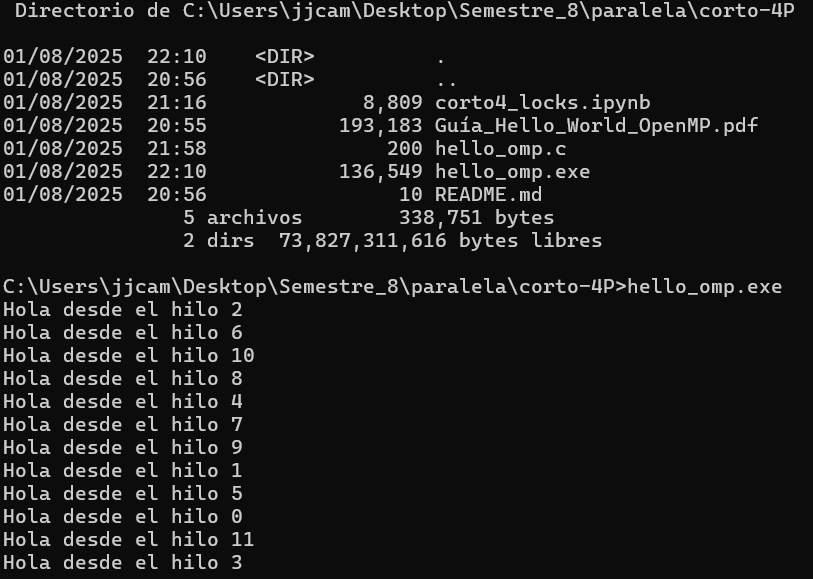